In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
 

In [2]:

%matplotlib notebook    
    
# Function defining the communication quality at a given position (Example function)
def communication_quality(x, y):
    alpha = 0.1
    return np.exp(-alpha * np.sqrt(x**2 + y**2))

# Function defining the coverage quality at a given position (Example function)
def coverage_quality(x, y):
    beta = 0.01
    return 1 / (1 + beta * np.sqrt(x**2 + y**2))

# Function defining the obstacle density at a given position (Example function)
def obstacle_density(x, y):
    gamma = 0.5
    obstacle_presence = np.logical_and(x > 0, np.logical_and(x < 5, np.logical_and(y > -2, y < 2)))
    return gamma * obstacle_presence.astype(float)


In [3]:

# Objective function combining communication quality, coverage, and obstacle avoidance
def objective_function(positions):
    w1, w2, w3 = 1, 1, 1  # Adjust weights based on importance
    x, y = positions[:, 0], positions[:, 1]
    
    return w1 * communication_quality(x, y) + w2 * coverage_quality(x, y) - w3 * obstacle_density(x, y)


In [4]:

# Particle Swarm Optimization (PSO) algorithm
def pso(objective_func, bounds, swarm_size=10, inertia=0.5, pa=0.8, ga=0.9, max_vnorm=10, num_iters=50):
    dim = len(bounds)
    bounds = np.array(bounds)
    particles = np.random.rand(swarm_size, dim) * (bounds[:,1]-bounds[:,0]) + bounds[:,0]
    velocities = np.random.rand(swarm_size, dim) * (bounds[:,1]-bounds[:,0]) + bounds[:,0]
    personal_bests = np.copy(particles)
    personal_best_fitness = objective_func(personal_bests)
    global_best_idx = np.argmin(personal_best_fitness)
    global_best = personal_bests[global_best_idx]
    global_best_fitness = personal_best_fitness[global_best_idx]
    global_best_fitness_history = []

    history = []  

    for i in range(num_iters):
        history.append(particles.copy())

        for p_i in range(swarm_size):
            fitness = objective_func(np.array([particles[p_i]]))
            if fitness < personal_best_fitness[p_i]:
                personal_bests[p_i] = particles[p_i]
                personal_best_fitness[p_i] = fitness
        
        if np.min(personal_best_fitness) < global_best_fitness:
            global_best_idx = np.argmin(personal_best_fitness)
            global_best = personal_bests[global_best_idx]
            global_best_fitness = personal_best_fitness[global_best_idx]

        velocities = inertia * velocities + pa * np.random.rand() * (personal_bests - particles) + ga * np.random.rand() * (global_best - particles)
        velocities = np.clip(velocities, -max_vnorm, max_vnorm)
        particles += velocities

        global_best_fitness_history.append(global_best_fitness)

    return np.array(history), global_best, global_best_fitness_history


In [5]:

def visualizeHistory2D(history, global_best_fitness, bounds, func_name, trail_length=2):
    x = np.linspace(bounds[0][0], bounds[0][1], 50)
    y = np.linspace(bounds[1][0], bounds[1][1], 50)
    X, Y = np.meshgrid(x, y)
    Z = objective_function(np.column_stack((X.flatten(), Y.flatten()))).reshape(X.shape)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.contour(X, Y, Z, levels=50, cmap="magma")
    lines = [ax1.plot([], [], '-o', markersize=3)[0] for _ in range(history.shape[1])]
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Global Best Fitness')
    ax2.set_title('Global Best Fitness over Time')
    fitness_line, = ax2.plot([], [], 'r-')
    ax2.set_xlim(0, len(global_best_fitness))
    ax2.set_ylim(np.min(global_best_fitness), np.max(global_best_fitness) + 0.1 * np.max(global_best_fitness))

    def init():
        for line in lines:
            line.set_data([], [])
        fitness_line.set_data([], [])
        return lines + [fitness_line]

    def animate(i):
        start_idx = max(0, i - trail_length)
        for j, line in enumerate(lines):
            line.set_data(history[start_idx:i + 1, j, 0], history[start_idx:i + 1, j, 1])
        fitness_line.set_data(range(i+1), global_best_fitness[:i+1])
        return lines + [fitness_line]

    ani = FuncAnimation(fig, animate, init_func=init, frames=len(history), interval=200, repeat=False)

    plt.suptitle(f'Optimization of {func_name}')
    plt.show()

    return ani


Global Best: [ 4.99998398 -1.99999954] Fitness: 1.0325145882935987


<IPython.core.display.Javascript object>


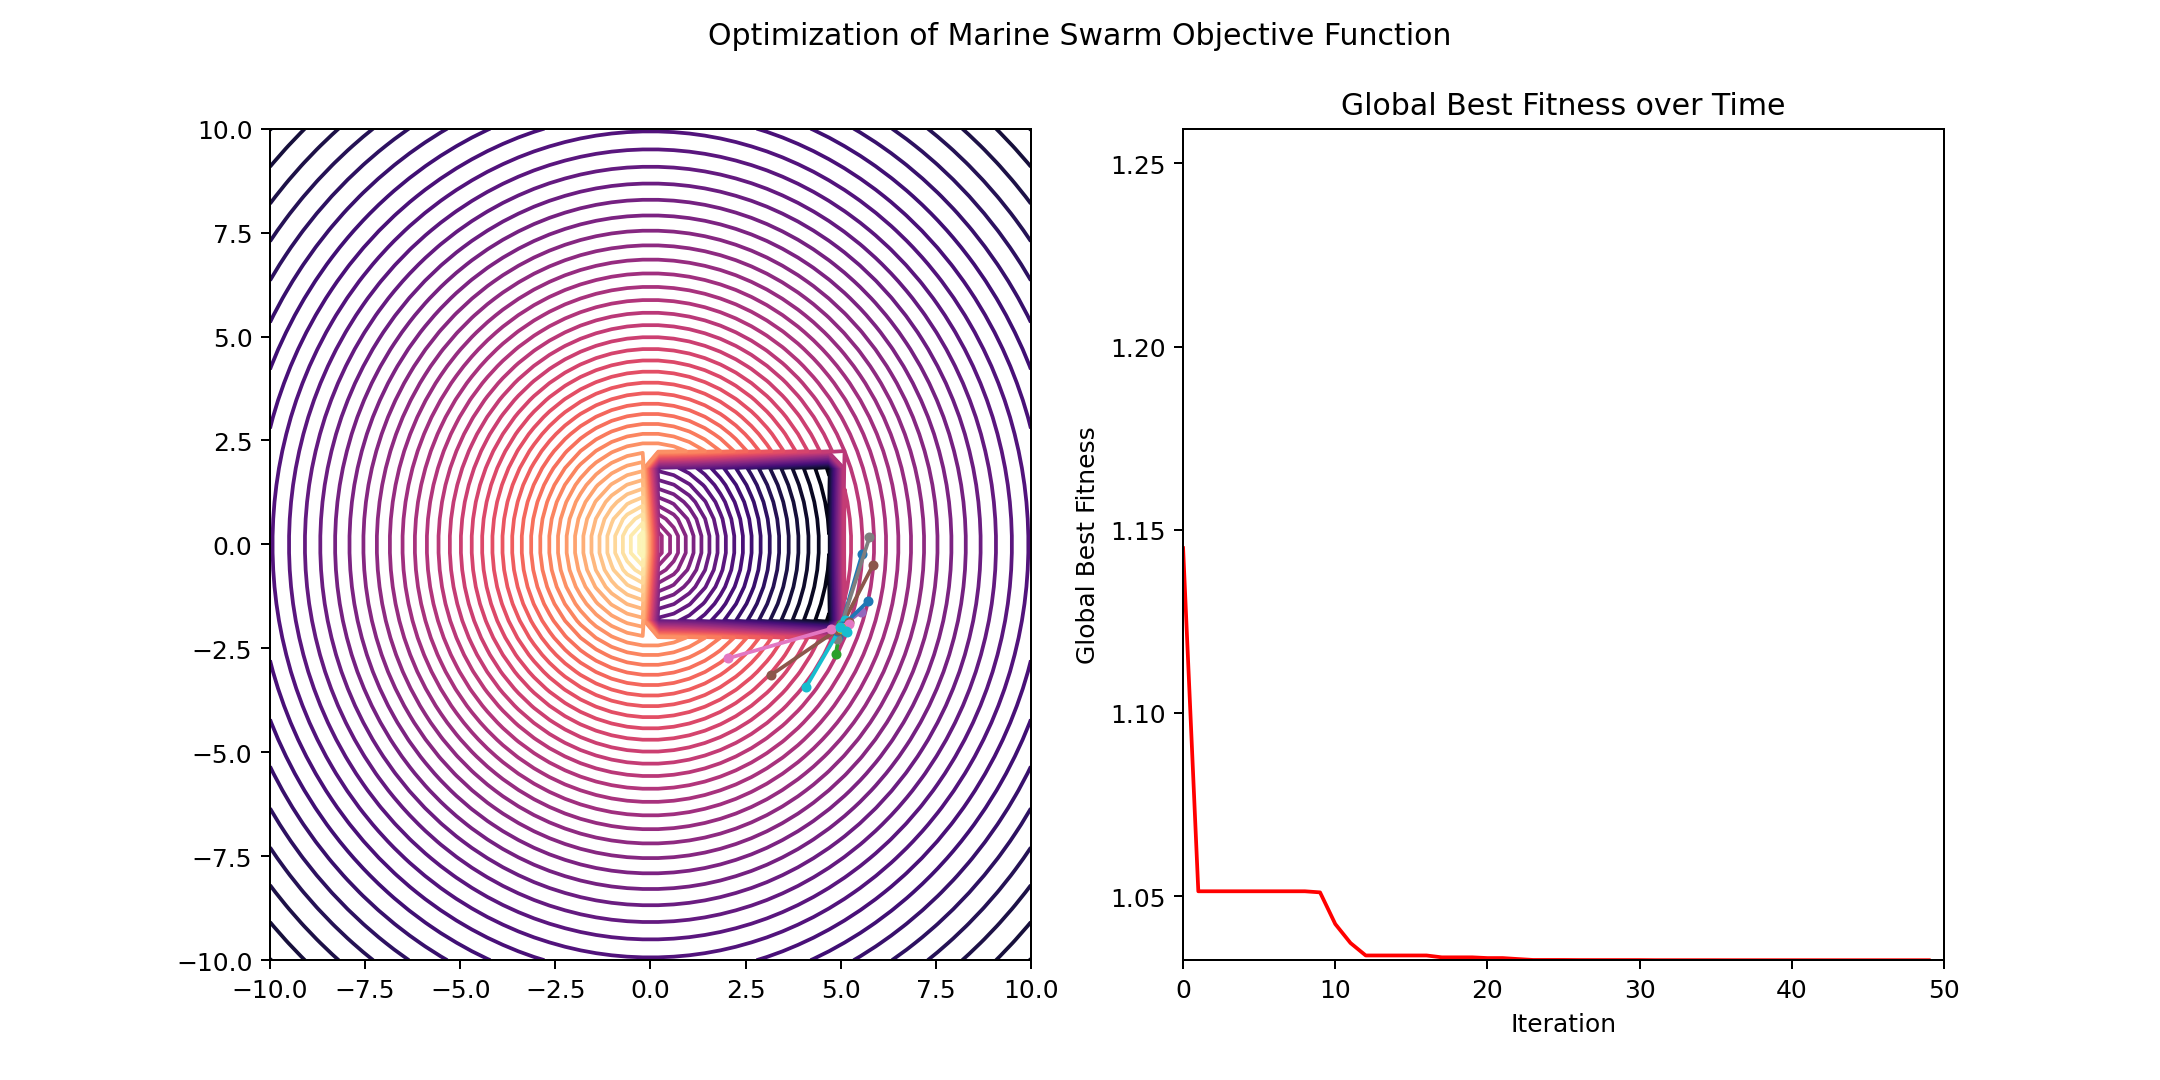

In [6]:

bounds = [[-10, 10], [-10, 10]]
history, global_best, global_best_fitness_history = pso(objective_function, bounds=bounds, swarm_size=30, num_iters=50)
print('Global Best:', global_best, 'Fitness:', global_best_fitness_history[-1])

ani = visualizeHistory2D(history, global_best_fitness_history, bounds=bounds, func_name='Marine Swarm Objective Function', trail_length=2)

plt.show()
